# <font color="steelblue">Энергетический оракул - Прогноз общего потребления электроэнергии за сутки</font>

**Задача**

Разработка модели прогнозирования общегоэнергопотребления региона на сутки, в МВтч

**Цель**

Разработать надежную и точную модель прогнозирования объема энергопотребления на сутки для Калининградской области с использованием доступных исторических данных и соответствующих переменных.

**Описание задачи**
В данной задаче необходимо разработать предиктивную модель, которая позволит прогнозировать энергопотребление региона на основе имеющихся данных о потреблении электроэнергии в прошлом и соответствующих факторах, влияющих на потребление энергии. Модель должна быть способна учесть сезонные, временные и другие зависимости для более точного прогноза.
Модель должна предсказывать общее потребление региона на 1 сутки.

**Замечание (!)**
Если мы делаем прогноз на сегодня, то у нас есть все данные за вчера и более ранние, но нет данных из будущего. Учесть это при конструировании признаков для модели.

**Описание данных**

<font color="steelblue"><b>*Для создания кейса использовались реальные данные.*</font></b>

- Обучающий датасет
содержит данные за период
2019 -01 -01– 2023 -03 -31
- Публичный тестовый датасет
представляет продолжение обучающего датасета. Содержит данные за период
2023-04-01 – 2023-07-31
- Приватный тестовый датасет
содержит данные за период
2023-08-01 – 2023-09-30

**Признаки:** 
- date – дата
- time – время, время представлено в диапазоне 0 – 23, что означает 24 часа в сутках

- temp – фактическая температура на указанную дату
- temp _pred _pred_pred – прогноз температуры на указанную дату
- weather_fact– фактическая погода на указанную дату
- weather_pred – прогноз погоды на указанную дату

**Целевой признак:**

- target – Фактическое потребление на указанную дату

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_path = "C:\\Users\\Natalia\\Desktop\\GlowByte\\"
data_path2 = 'datasets/'

if os.path.exists(f"{data_path}train_dataset.csv"):
    train = pd.read_csv(f"{data_path}train_dataset.csv")
    test = pd.read_csv(f"{data_path}test_dataset.csv")
    holidays = pd.read_csv(f"{data_path}holidays_covid.csv")
    sun_day_length = pd.read_csv(f"{data_path}sun_day_length.csv") 
    holidays_sun_length = pd.read_csv(f"{data_path}holidays_sun_length.csv") 
    
elif os.path.exists(f"{data_path2}train_dataset.csv"):
    train = pd.read_csv(f"{data_path2}train_dataset.csv")
    test = pd.read_csv(f"{data_path2}test_dataset.csv")
    holidays = pd.read_csv(f"{data_path2}holidays_covid.csv")
    day_length = pd.read_csv(f"{data_path2}day_length.csv", sep=';')
    
else:
    print("Файлы не найдены. Проверьте путь к файлам.")

# Анализ данных 

Подготовимфункции для анализа данных 

In [5]:
def display_dataset_info(dataset, name):
    
    display(Markdown(f"**~~~~~~~ {name} ~~~~~~~**"))
    display(Markdown("**Общая информация о датасете**")) 
    display(dataset.head())
    display(dataset.info())
    display(Markdown("**Cтатистическое описание числовых признаков**"))
    display(dataset.describe())
    display(Markdown('**Количество пропусков в датасете**'))
    print(dataset.isna().sum())
    display(Markdown('**Дубликаты**'))
    print('Количество явных дубликатов:', dataset.duplicated().sum())
    print('-'*50)

    display(Markdown('**Статистическое описание числовых признаков с цветовым выделением**'))
    desc = dataset.describe()
    color = sns.light_palette("#6E237D", as_cmap=True)
    styled_desc = desc.style.background_gradient(cmap=color)
    display(styled_desc)
    
    display(Markdown('**Гистограммы числовых значений**'))
    dataset.hist(figsize=(9, 9), bins=50, color='#003C96',
                 edgecolor='blue', linewidth=1.2, alpha=0.7)


In [6]:
def plot_box_strip(dataset, columns):
    for i in columns:
        plt.subplots(figsize=(15, 2))
        ax = sns.boxplot(data=dataset[i], color='#003C96', orient="h")
        ax = sns.stripplot(data=dataset[i], orient="h", 
                           color="orangered", jitter=0.2, size=2.5)
        plt.title(i, loc="left")
        plt.show()

In [7]:
def plot_hist(dataset, columns, bins):
    for column in columns:
        dataset[column].hist(bins=bins, figsize=(
            10, 10), color='#003C96', edgecolor='blue', linewidth=1.2, alpha=0.7)
        plt.title(f'Гистограмма столбца {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()

Загрузим и исследуем обучающий датасет

**~~~~~~~ Обучающая выборка  ~~~~~~~**

**Общая информация о датасете**

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


None

**Cтатистическое описание числовых признаков**

,time,target,temp,temp_pred
count,37224.00000,37224.000000,37224.000000,37136.000000
mean,11.50000,483.731441,8.748995,8.768984
std,6.92228,101.459375,8.125722,8.017520
min,0.00000,198.982000,-21.700000,-20.000000
25%,5.75000,418.950750,2.600000,3.000000
50%,11.50000,473.064000,7.900000,8.000000
75%,17.25000,561.217000,14.700000,15.000000
max,23.00000,767.888000,32.500000,33.000000


**Количество пропусков в датасете**

date             0
time             0
target           0
temp             0
temp_pred       88
weather_pred    88
weather_fact     1
dtype: int64


**Дубликаты**

Количество явных дубликатов: 0
--------------------------------------------------


**Статистическое описание числовых признаков с цветовым выделением**

,time,target,temp,temp_pred
count,37224.000000,37224.000000,37224.000000,37136.000000
mean,11.500000,483.731441,8.748995,8.768984
std,6.922280,101.459375,8.125722,8.017520
min,0.000000,198.982000,-21.700000,-20.000000
25%,5.750000,418.950750,2.600000,3.000000
50%,11.500000,473.064000,7.900000,8.000000
75%,17.250000,561.217000,14.700000,15.000000
max,23.000000,767.888000,32.500000,33.000000


**Гистограммы числовых значений**

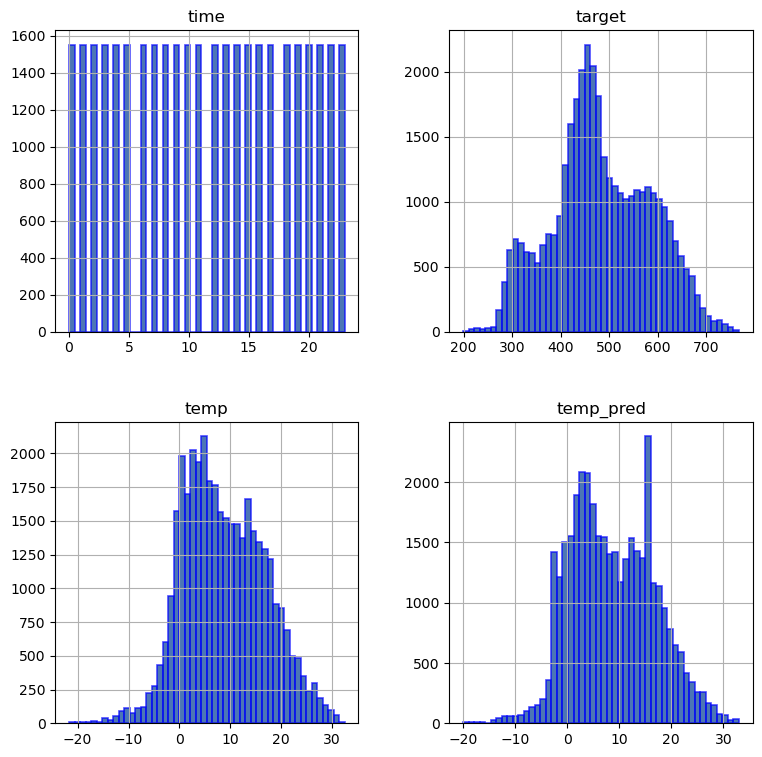

In [8]:
display_dataset_info(train, 'Обучающая выборка ')

In [9]:
display(Markdown("**Подсчёт кол-ва уникальных значений погоды и температуры**")) 

for column in train.columns[3:]:
    unique_values = train[column].unique()
    count_unique = len(unique_values)
    print(f'Кол-во уникальных значений в столбце "{column}": {count_unique}')


**Подсчёт кол-ва уникальных значений погоды и температуры**

Кол-во уникальных значений в столбце "temp": 474
Кол-во уникальных значений в столбце "temp_pred": 55
Кол-во уникальных значений в столбце "weather_pred": 2182
Кол-во уникальных значений в столбце "weather_fact": 581


In [10]:
display(Markdown("**Уникальные значения в столбце weather_fact**")) 
print(train["weather_fact"].unique())

**Уникальные значения в столбце weather_fact**

['ветер' 'ветер, пасм' 'ветер, пасм,дождь' 'ветер, ливень'
 'пасм, ветер, дождь' 'пасм, ветер' 'пасм, ветер, снег, метель'
 'пасм,ветер' 'ясно, ветер' 'пасм, дождь' 'дождь' 'облачно' 'малообл'
 'пасмурно' 'снег, пасм' 'ясно' 'пасм, снег' 'пасм, снег, ветер'
 'пасм,снег' 'снег' 'прояснения' 'пасм, морось, ветер' 'пасм, морось'
 'обл с проясн' 'пасм дождь' 'пасм дождь, ветер' 'пасм,снег, дождь, ветер'
 'облачно, снег, ветер' 'п/обл, ветер, вр снег' 'ветер, снег'
 'п/обл, ветер' 'пасм, ветер, снег' 'п/обл' 'пасмурно, дождь' 'пасм'
 'дымка' 'облачно, снежок)' 'облачно, снег' 'пер.обл.' 'малообл.'
 'обл., снег' 'обл., слабый снег' 'обл., мокрый снег' 'обл., морось'
 'обл., дождик' 'туман' 'ледяной туман' 'облачно, дымка' 'пасм., снежок'
 'пасм, дождь, снег' 'пасм,, мокр снег' 'мокр снег' 'облачно, дождь'
 'пасм, дождь, ветер' 'пасм, снежок' 'пасм, мокр снег' 'обл.,морось'
 'обл., сыро' 'пасм., морось' 'дымка, морось' 'дымка ' 'пасм.,морось'
 'пасм.,дождик' 'облачно, ветер' 'пасмурно, ветер'

## Предоработка данных и добавление признаков 

In [11]:
#Заполним пропуски температуры предыдущим значением 
train['temp_pred'] = train['temp_pred'].fillna(train['temp_pred'].shift(-1,fill_value=0))

In [12]:
# удалим столбец ремени, поскольку предсказваем не по часам, а за сутки 
train = train.drop(['time'], axis=1)

Напишем функцию, которая преобразует столбец дату к добавит к датасету признаки дня недели, выходных, неделя, а также сделает столбцы для недели и номера недели с преобразованием через косинус, а также добавляет лаги.

In [13]:
def get_features(df):

    #преобразование даты в нужной формат и создание дня недели
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday 
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    # преобразуем день недели и номер недели через косинус    
    df['weekday_cos'] =  np.cos((2 * np.pi) / 7 * (df['weekday'] + 1))
    
    df['week_cos'] = df['date'].dt.isocalendar().week
    df['week_cos'] =  np.cos((2 * np.pi) / 53 * (df['week_cos'] + 1))
#     #добавляем лаги 
#     for lag in [lag1, lag2]:
#         df['lag_{}'.format(lag)] = df['target'].shift(lag)
#         df['lag_{}'.format(lag)] = df['lag_{}'.format(lag)].fillna(df['lag_{}'.format(lag)].median())
    
    df.index = df['date']
    df = df.drop('date', axis=1)
    df.sort_index(inplace = True)

    return df


In [14]:
train = get_features(train) # 1464, 8760, 17520
train.head()

,target,temp,temp_pred,weather_pred,weather_fact,weekday,weekend,weekday_cos,week_cos
date,,,,,,,,,
2019-01-01,481.510,2.9,2.0,"пасм, ветер",ветер,1,False,-0.222521,0.972023
2019-01-01,462.872,2.9,2.0,"пасм, ветер",ветер,1,False,-0.222521,0.972023
2019-01-01,449.718,2.9,2.0,"пасм, ветер",ветер,1,False,-0.222521,0.972023
2019-01-01,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",1,False,-0.222521,0.972023
2019-01-01,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",1,False,-0.222521,0.972023


### Анализ временных рядов

In [15]:
# Ресемплирование данных
def resample_data(data, resampling_method):

    resampled_data = data.resample(resampling_method).agg({
        'temp': 'median',
        'temp_pred': 'median',
        'weekday': 'median',
        'weekend': 'median',
        'weekday_cos': 'median',
        'week_cos': 'median',
#         'lag_1464': 'median',
#         'lag_8760': 'median',
#         'lag_17520': 'median',
#         'lag_1': 'median',
#         'lag_24': 'median',
#         'lag_168': 'median',
        'target': 'sum',
        'weather_pred': 'sum',
        'weather_fact': 'sum'
    })
    
    return resampled_data

In [16]:
# Графики временных рядов, тренд и сезонность 
def plot_resampled_data(resampled_data, how):
    display(Markdown('**Временные ряды**'))
    custom_palette = sns.color_palette("husl", n_colors=len(resampled_data.columns))
    sns.set_palette(custom_palette)

    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax2 = ax1.twinx()

    resampled_data[['temp', 'temp_pred']].plot(ax=ax1, color=custom_palette[:3])
    ax1.set_ylabel('Температуры (суточная медиана)', color='red')

    resampled_data[['target']].plot(ax=ax2, color='#3CB371')
    ax2.set_ylabel('Энергопотребление за сутки', color='green')

    plt.title(f"Временной ряд энергопотребления и температуры(по {how})")
    plt.show()
    
    display(Markdown('**Тренды и сезонность**'))
    decomposed = seasonal_decompose(resampled_data['target'])

    plt.figure(figsize=(15, 7))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), color='#00FA9A')
    plt.title('Тренд')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca(), color='#FF6347')
    plt.title('Сезонность')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca(), color='#9ACD32')
    plt.title('Остаток')
    plt.tight_layout()
    plt.show()

In [17]:
# Ресемплирование данных
resampled_day= resample_data(train,'D') 

**Графики для данных, ресемплированных по дню**

**Временные ряды**

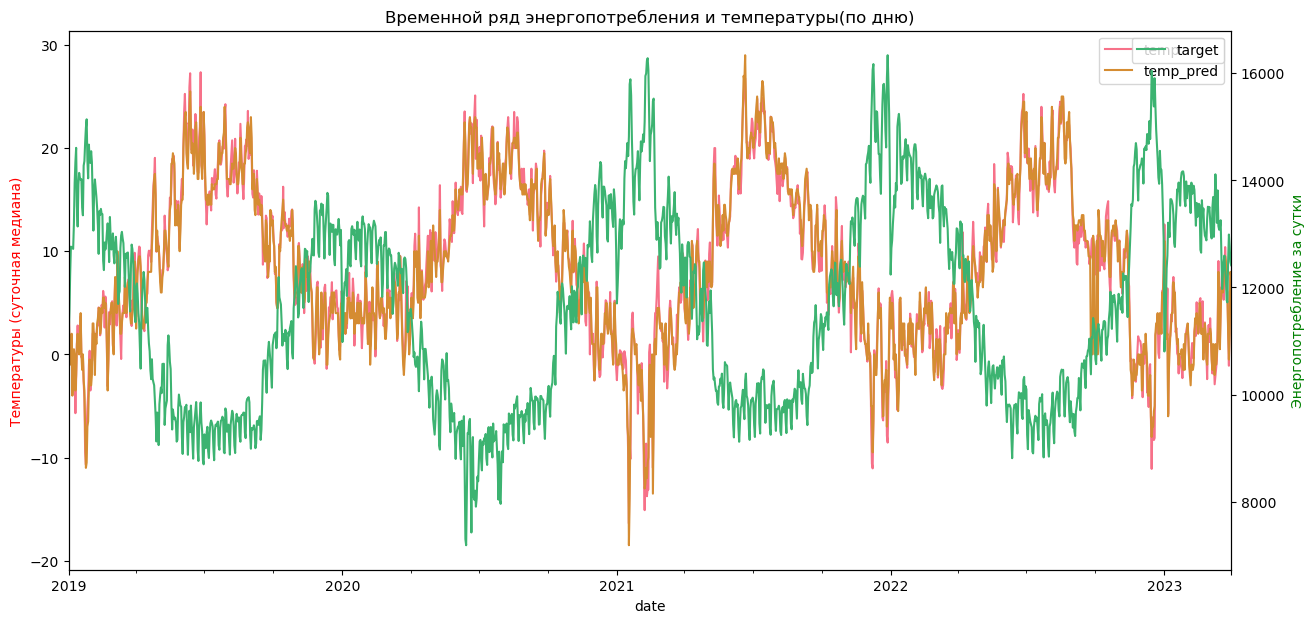

**Тренды и сезонность**

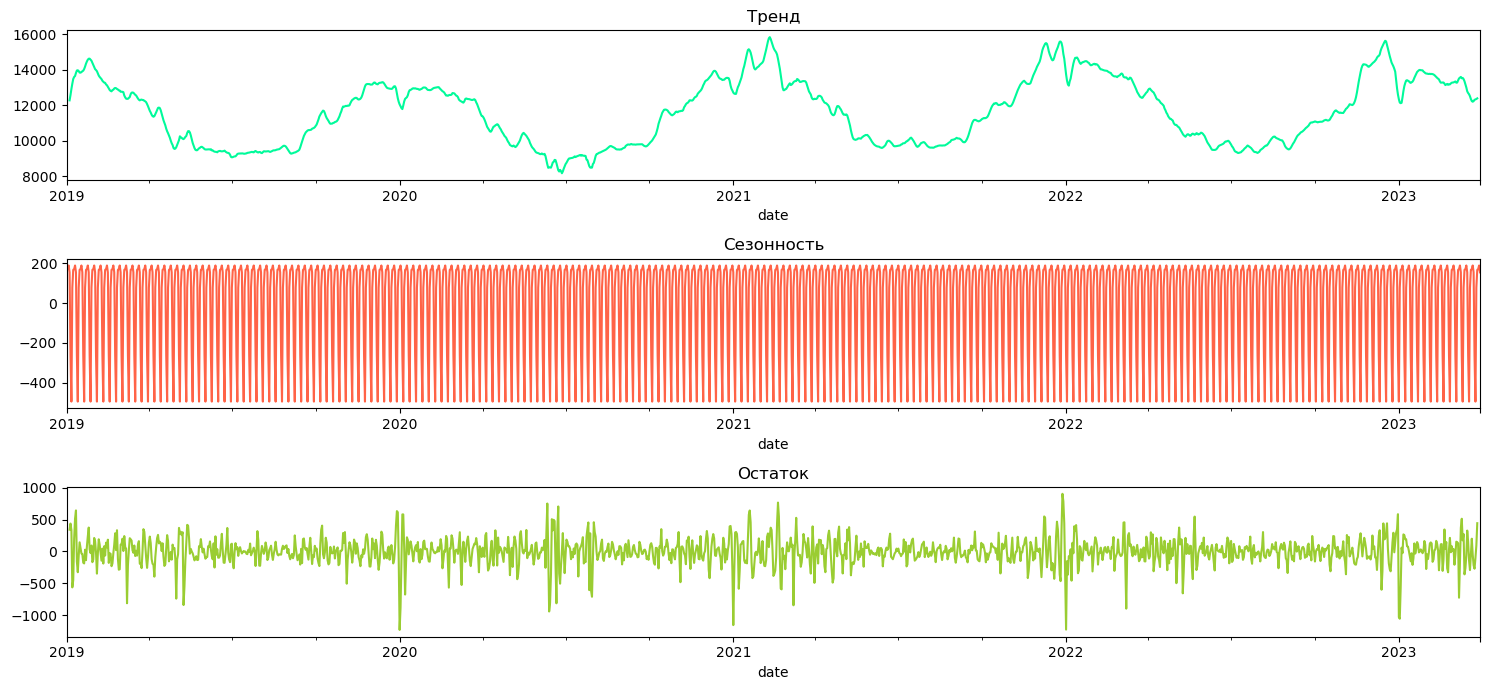

In [18]:
plot_resampled_data(resampled_day, how='дню')

### Добавление фичей (продолжительность светового дня, ковид, день недели и праздники)

Добавим длину светового дня и прадники и ковид 

In [19]:
def process_holidays(resampled_day, holidays_sun_length):
    holidays_sun_length['date'] = pd.to_datetime(holidays_sun_length['date'], format="%Y-%m-%d")
    holidays_sun_length = holidays_sun_length.drop(['Unnamed: 0'], axis=1)
    resampled_day_merged = resampled_day.merge(holidays_sun_length, on='date', how='left')
    resampled_day_merged = resampled_day_merged.set_index('date')
    resampled_day_merged.sort_index(inplace=True)
    return resampled_day_merged

In [20]:
resampled_day_merged = process_holidays(resampled_day, holidays_sun_length)
resampled_day_merged.head()

,temp,temp_pred,weekday,weekend,weekday_cos,week_cos,target,weather_pred,weather_fact,sun_day_dec_hours,holiday,covid
date,,,,,,,,,,,,
2019-01-01,5.00,5.0,1.0,0.0,-0.222521,0.972023,11126.866,"пасм, ветерпасм, ветерпасм, ветерпасм, ветерпа...","ветерветерветерветер, пасмветер, пасмветер, па...",7.426667,1,0
2019-01-02,1.05,1.0,2.0,0.0,-0.900969,0.972023,11547.210,"пасм, ветер, 76% дождьпасм, ветер, 76% дождьпа...","пасм, ветер, дождьпасм, ветер, дождьпасм, вете...",7.449444,1,0
2019-01-03,-0.65,-1.0,3.0,0.0,-0.900969,0.972023,12235.564,"пасм, 52% снегпасм, 52% снегпасм, 52% снегпасм...","пасм,ветерпасм,ветерпасм,ветерпасм,ветерпасм,в...",7.474444,1,0
2019-01-04,-0.05,0.0,4.0,0.0,-0.222521,0.972023,12763.044,"пасм, 36% снегпасм, 36% снегпасм, 36% снегпасм...","пасм, ветерпасм, ветерпасм, ветерпасм, ветерпа...",7.500833,1,0
2019-01-05,0.70,2.0,5.0,1.0,0.623490,0.972023,12735.145,"пасм, 74% дождь,, снегпасм, 74% дождь,, снегпа...",дождьдождьдождьдождьдождьдождьоблачнооблачнооб...,7.529444,1,0


Мы НЕ МОЖЕМ использовать факт погоды/температуры на завтра и завтрашний таргет, потому что в реальности этими данными мы не обладаем, т.к. завтра еще НЕ НАСТУПИЛО. 

Поскольку пока нет возможности "добывать" данне по погоде для тестового датасета (прогноз погод), то и для обучения столбцы weather_pred и weather_fact использовать не имеет смысла. Удалим их. 

In [21]:
resampled_day_merged = resampled_day_merged.drop(['weather_pred', 'weather_fact'], axis=1) 
resampled_day_merged.head()

,temp,temp_pred,weekday,weekend,weekday_cos,week_cos,target,sun_day_dec_hours,holiday,covid
date,,,,,,,,,,
2019-01-01,5.00,5.0,1.0,0.0,-0.222521,0.972023,11126.866,7.426667,1,0
2019-01-02,1.05,1.0,2.0,0.0,-0.900969,0.972023,11547.210,7.449444,1,0
2019-01-03,-0.65,-1.0,3.0,0.0,-0.900969,0.972023,12235.564,7.474444,1,0
2019-01-04,-0.05,0.0,4.0,0.0,-0.222521,0.972023,12763.044,7.500833,1,0
2019-01-05,0.70,2.0,5.0,1.0,0.623490,0.972023,12735.145,7.529444,1,0


Изучим, как отличается температура действительная от предсказанной.

In [22]:
resampled_day_merged['temp_mismatch'] = resampled_day_merged['temp'] - resampled_day_merged['temp_pred']

In [23]:
resampled_day_merged.head()

,temp,temp_pred,weekday,weekend,weekday_cos,week_cos,target,sun_day_dec_hours,holiday,covid,temp_mismatch
date,,,,,,,,,,,
2019-01-01,5.00,5.0,1.0,0.0,-0.222521,0.972023,11126.866,7.426667,1,0,0.00
2019-01-02,1.05,1.0,2.0,0.0,-0.900969,0.972023,11547.210,7.449444,1,0,0.05
2019-01-03,-0.65,-1.0,3.0,0.0,-0.900969,0.972023,12235.564,7.474444,1,0,0.35
2019-01-04,-0.05,0.0,4.0,0.0,-0.222521,0.972023,12763.044,7.500833,1,0,-0.05
2019-01-05,0.70,2.0,5.0,1.0,0.623490,0.972023,12735.145,7.529444,1,0,-1.30


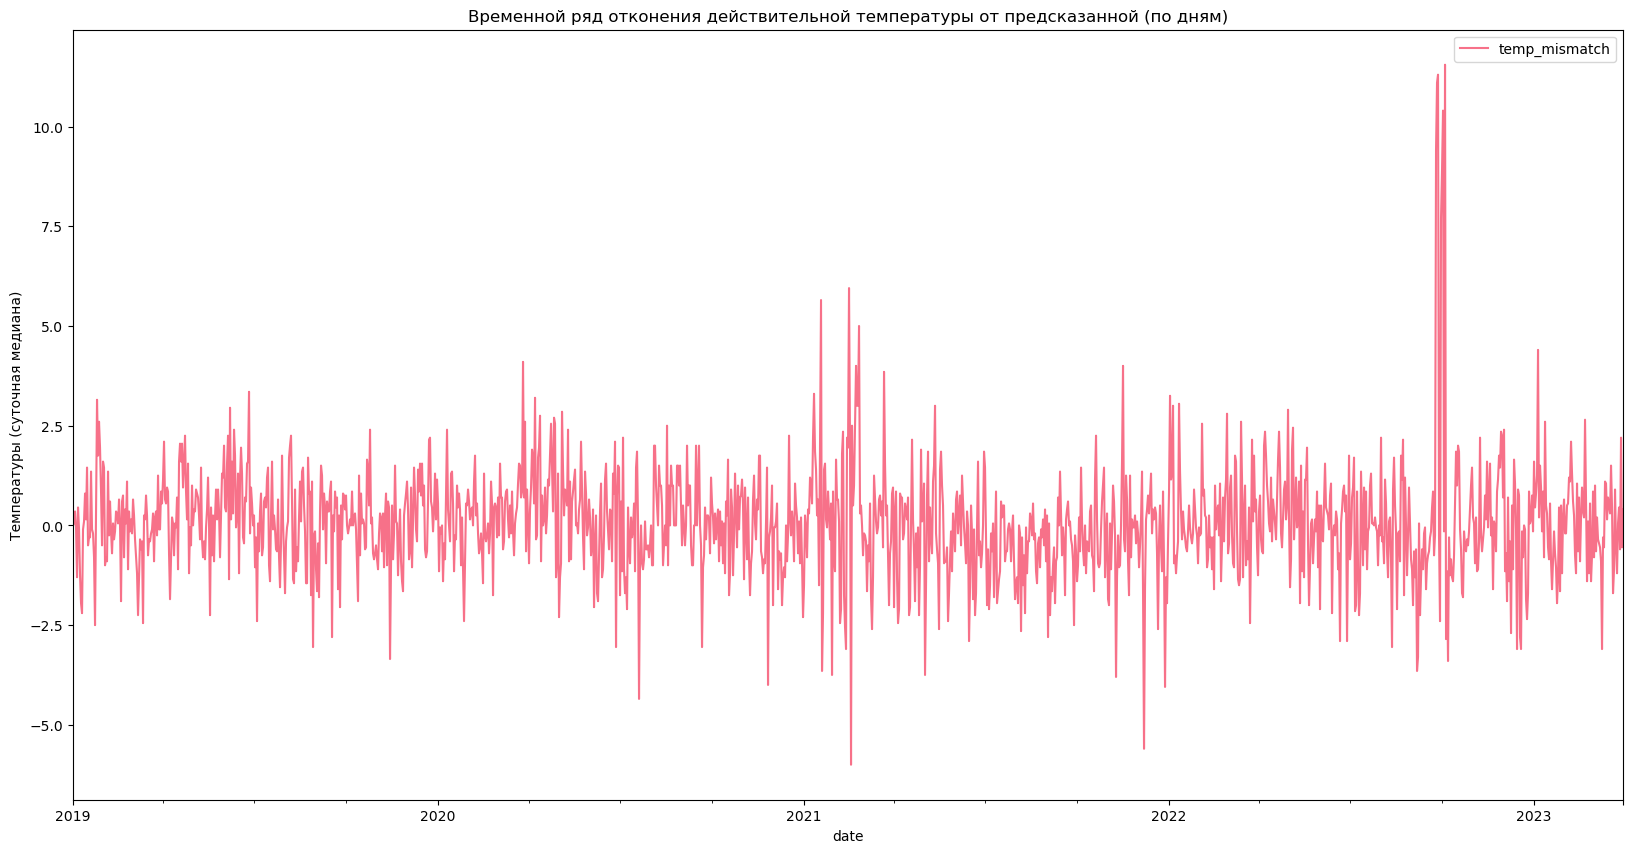

In [24]:
custom_palette = sns.color_palette("husl", n_colors=len(resampled_day_merged.columns))
sns.set_palette(custom_palette)

fig, ax = plt.subplots(figsize=(20, 10)) 

resampled_day_merged[['temp_mismatch']].plot(ax=ax)
ax.set_ylabel('Температуры (суточная медиана)')

plt.title("Временной ряд отконения действительной температуры от предсказанной (по дням)")
plt.show()


Посмотрим на диаграмму размаха дельты температур

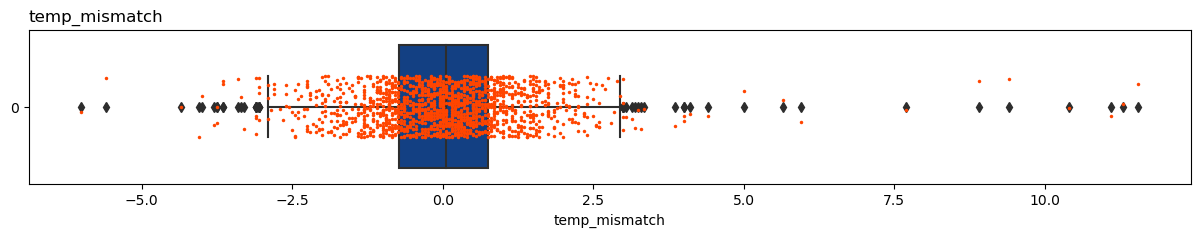

In [25]:
plot_box_strip(resampled_day_merged, ['temp_mismatch'])

In [26]:
resampled_day_merged['temp_mismatch'].describe()

count    1551.000000
mean        0.059349
std         1.387353
min        -6.000000
25%        -0.725000
50%         0.050000
75%         0.750000
max        11.550000
Name: temp_mismatch, dtype: float64

Основная дельта температур (действительной и предсказанной) колеблется в интервале +/-0.7 градусов (судя по диаграмме размаха). Есть и более значительне отличия температур, но таких точек намного. 
Можно считать, что предсказания довольно точные. 

Удалим столббец с дельтой и действителной температурой, поскольку для для прогноза мы не можем использовать эти данные, а значит и на обучении не будем. 

In [27]:
resampled_day_merged = resampled_day_merged.drop(['temp', 'temp_mismatch'], axis=1) 
resampled_day_merged.head()

,temp_pred,weekday,weekend,weekday_cos,week_cos,target,sun_day_dec_hours,holiday,covid
date,,,,,,,,,
2019-01-01,5.0,1.0,0.0,-0.222521,0.972023,11126.866,7.426667,1,0
2019-01-02,1.0,2.0,0.0,-0.900969,0.972023,11547.210,7.449444,1,0
2019-01-03,-1.0,3.0,0.0,-0.900969,0.972023,12235.564,7.474444,1,0
2019-01-04,0.0,4.0,0.0,-0.222521,0.972023,12763.044,7.500833,1,0
2019-01-05,2.0,5.0,1.0,0.623490,0.972023,12735.145,7.529444,1,0


## Моделирование  

### Подготовка к обучению 
Разделение данных на обучающую и тестовую выборки и выделение признаков и целевого признака

In [28]:
X = resampled_day_merged.drop(['target'], axis=1)
y = resampled_day_merged['target']

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=.1)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1395, 8), (156, 8), (1395,), (156,))

### Создание и обучение модели  

Создадим функцию для определения качества моделей, а также для поиска наилучших параметров моделей с помощью кроссвалидации в составе GridSearchCV.

Также будем использовать кросс-валидатор временных рядов. Он разделяет временной ряд на выборкис фиксированными промежутками времени. В каждом разделе тестовые индексы должны быть выше, чем в предыдущем, и поэтому перестановка в перекрестном валидаторе неуместна.

In [30]:
tscv = TimeSeriesSplit(n_splits=round((X_train.shape[0] / X_valid.shape[0]) - 1))

In [31]:
def model_results(model, params, X_train, X_valid, y_train, y_valid):
    
    grid_search = GridSearchCV(model,
                      param_grid=params,
                      cv=tscv,
                      scoring='neg_mean_absolute_error',
                      n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    
    # Теперь, когда лучшие параметры найдены, оценим модель по другим метрикам
    model_with_best_params = model.set_params(**best_params)
    model_with_best_params.fit(X_train, y_train)
    y_pred = model_with_best_params.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    return mae, mape, r2, best_params


Обозначим гиперпараметры, которые будут перебираться в grid_search

In [32]:
param_grid_xgb = {
    'n_estimators': [100, 200], 
    'max_depth': [6, 8], 
    'eta': [0.01, 0.1] 
}

param_grid_cat = {
    'iterations': [100, 200], 
    'depth': [6, 8], 
    'learning_rate': [0.01, 0.1]  
}

**XGBRegressor**

In [33]:
mae_xgb, mape_xgb, r2_xgb, best_params_xgb = model_results(
    XGBRegressor(), param_grid_xgb, X_train, X_valid, y_train, y_valid)


print('Параметр лучшей модели:', best_params_xgb)
print('MAE модели: ', round(mae_xgb, 3))
print('MPAE модели: ', round(mape_xgb, 3))
print('R2 модели: ', round(r2_xgb, 3))

Параметр лучшей модели: {'eta': 0.1, 'max_depth': 6, 'n_estimators': 100}
MAE модели:  382.74
MPAE модели:  0.029
R2 модели:  0.753


**CatBoostRegressor** 

In [34]:
mae_cat, mape_cat, r2_cat, best_params_cat = model_results(
    CatBoostRegressor(silent=True, loss_function='MAE'), param_grid_cat, X_train, X_valid, y_train, y_valid)


print('Параметр лучшей модели:', best_params_cat)
print('MAE модели: ', round(mae_cat, 3))
print('MPAE модели: ', round(mape_cat, 3))
print('R2 модели: ', round(r2_cat, 3))

Параметр лучшей модели: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MAE модели:  368.689
MPAE модели:  0.027
R2 модели:  0.772


####  Обучим лучшую модель на всем обучающем датасете 

In [35]:
%%time 
best_model = CatBoostRegressor(silent=True, **best_params_cat).fit(X, y)

CPU times: total: 1.2 s
Wall time: 823 ms


### Тестирование лучшей модели

#### Подготовка тестового датасета 

In [36]:
test.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


In [37]:
def preprocess_test_data(df, holidays_sun_length):

    #Заполним пропуски температуры предыдущим значением 
    df['temp_pred'] = df['temp_pred'].fillna(df['temp_pred'].shift(-1,fill_value=0))

    # удалим столбец ремени, поскольку предсказваем не по часам, а за сутки 
    df = df.drop(['time', 'weather_pred', 'weather_fact', 'temp'], axis=1)
    #преобразование даты в нужной формат и создание дня недели
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday 
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    # преобразуем день недели и номер недели через косинус    
    df['weekday_cos'] =  np.cos((2 * np.pi) / 7 * (df['weekday'] + 1))
    
    df['week_cos'] = df['date'].dt.isocalendar().week
    df['week_cos'] =  np.cos((2 * np.pi) / 53 * (df['week_cos'] + 1))
#     #добавляем лаги 
#     for lag in [lag1, lag2]:
#         df['lag_{}'.format(lag)] = df['target'].shift(lag)
#         df['lag_{}'.format(lag)] = df['lag_{}'.format(lag)].fillna(df['lag_{}'.format(lag)].median())
    
    df.index = df['date']
    df = df.drop('date', axis=1)
    df.sort_index(inplace = True)

    # Ресемплирование данных
    resampled_df = df.resample('D').agg({
        'temp_pred': 'median',
        'weekday': 'median',
        'weekend': 'median',
        'weekday_cos': 'median',
        'week_cos': 'median',
#         'lag_24': 'median',
#         'lag_168': 'median',
        'target': 'sum',
    })
    
    holidays_sun_length['date'] = pd.to_datetime(holidays_sun_length['date'], format="%Y-%m-%d")
    holidays_sun_length = holidays_sun_length.drop(['Unnamed: 0'], axis=1)
    resampled_day_merged = resampled_df.merge(holidays_sun_length, on='date', how='left')
    resampled_day_merged = resampled_day_merged.set_index('date')
    resampled_day_merged.sort_index(inplace=True)
    
    return resampled_day_merged



In [38]:
test_processed = preprocess_test_data(test, holidays_sun_length)
test_processed

,temp_pred,weekday,weekend,weekday_cos,week_cos,target,sun_day_dec_hours,holiday,covid
date,,,,,,,,,
2023-04-01,4.0,5.0,1.0,0.623490,-0.088796,12145.176,13.113611,1,0
2023-04-02,2.0,6.0,1.0,1.000000,-0.088796,12026.069,13.187500,1,0
2023-04-03,1.5,0.0,0.0,0.623490,-0.205979,12633.976,13.261667,0,0
2023-04-04,0.5,1.0,0.0,-0.222521,-0.205979,13042.841,13.335556,0,0
2023-04-05,1.5,2.0,0.0,-0.900969,-0.205979,13074.646,13.409444,0,0
...,...,...,...,...,...,...,...,...,...
2023-07-27,17.0,3.0,0.0,-0.900969,-0.861044,9676.911,16.243333,0,0
2023-07-28,16.0,4.0,0.0,-0.222521,-0.861044,9754.812,16.186111,0,0
2023-07-29,19.5,5.0,1.0,0.623490,-0.861044,9525.396,16.128333,1,0


Разделим тестовый датасет на признак и целевой признак 

In [39]:
X_test = test_processed.drop(['target'], axis=1)
y_test = test_processed['target']

Предсказание на лучшей модели: 

In [40]:
y_pred = best_model.predict(X_test)
    
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print('MAE модели на тесте: ', round(mae_test, 3))
print('MPAE модели на тесте: ', round(mape_test, 3))
print('R2 модели на тесте: ', round(r2_test, 3))

MAE модели на тесте:  264.204
MPAE модели на тесте:  0.026
R2 модели на тесте:  0.803


**ВЫВОД:** 

- Обучены две бустинговые модели CatBoostRegressor и XGBRegressor, с прдбором гиперапараметров и кросс валидацией с применением GridSearchCV. 
- Обучена и протестирована на открытом тестовом датасете лучшая модель CatBoostRegressor с наилучшими параметрами {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}. 
- Лучшая модель на тесте имеет следующие значения метрик: 
  - Значение MAE (Mean Absolute Error) равно 264 МВтч, то есть среднем модель делает ошибку в прогнозе потребления электроэнергии размером около 264 МВтч.

  - Значение MPAE равно 0.026, что означает в среднем модель ошибается на 2.6% относительно фактического потребления электроэнергии.

  - Значение R2 равно 0.803. Это означает, что ваша модель объясняет примерно 80.3% вариабельности в потреблении электроэнергии, измеренной в МВт*ч.

 <img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>

**Как поднять метрику** 

Тестовый датасет содержит данные за период 2023-04-01 – 2023-07-31 (три месяца), а скрытый тестовый датасет содержит данные за период 2023-08-01 – 2023-09-30 (два месяца). 
В таком случае почти на всех точках мы не сможем получить значение лага как признака  для прогнозирования (например, лаги 1 день и 7 дней дают хороший прирост). Горизонт прогноза определяет минимальный лаг, которым модель может воспользоваться. Если мы добавляем лаги с учетом этого условия, то прирост метрики не получаем. 

Если мы делаем прогноз на сегодня, то у нас есть все данные за вчера и более ранние, но нет данных из будущего. Учесть это при конструировании признаков для модели.
Что использовать лаги, нужно прогнозировать на день вперед, а не на всю длину тестового датасета (три месяца или два, как скрытй). 
На следующий день дообучать модель с новым фактическим значением потребления энергии и снова делать прогноз на день вперед. 

